In [1]:
import os
import cv2
import csv
import random
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
%load_ext tensorboard
import datetime

## Preprocess Videos

In [26]:
def preprocess_frame(frame):
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = tf.image.resize(frame, (224,224))
    #frame = frame / 255.0  # Normalize pixel values
    return frame
    
def preprocess_video(video_path, signer):
    frames = []
    if os.path.exists(video_path):
        cap = cv2.VideoCapture(video_path)

        label = video_path.split("/")[5]
        folder_path = f"D:/WLASL/KArSL/all Signers/Test/{label}"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        t = 0
        while True:
            ret, cur_frame = cap.read()
            name = video_path.split("_")[9]
            if not os.path.exists(f"{folder_path}/{name}_{t}_{signer}.png"):
                if not ret:
                    break
                frame = preprocess_frame(cur_frame)
                frame = frame.numpy()
                #frames.append(cur_frame)
                cv2.imwrite(f"{folder_path}/{name}_{t}_{signer}.png", frame)
            t += 1
        #fin_frames = stack_images(frames)
        #print(len(fin_frames))
        #for fram in fin_frames:
        #    name = video_path.split("_")[9]
        #    cv2.imwrite(f"{folder_path}/{name}_{t}.png", fram)
        #    t += 1
        cap.release()

    else:
        return 0

In [ ]:
data_dir = "D:/WLASL/KArSL/Signer_1/Train"
data_dir2 = "D:/WLASL/KArSL/Signer_2/Train"
data_dir3 = "D:/WLASL/KArSL/Signer_3/Train"
classes_to_preprocess = ["0160", "0162", "0169", "0173", "0174", "0230", "0231", "0265", "0272", "0290", 
                         "0294", "0296", "0299", "0343", "0459", "0468", "0487", "0497", "0501", "0502"]

for clas in tqdm(os.listdir(data_dir)):
    if clas in classes_to_preprocess:
        for vid in os.listdir(f"{data_dir}/{clas}"):
            preprocess_video(f"{data_dir}/{clas}/{vid}", "1")
            
for clas in tqdm(os.listdir(data_dir2)):
    if clas in classes_to_preprocess:
        for vid in os.listdir(f"{data_dir}/{clas}"):
            preprocess_video(f"{data_dir}/{clas}/{vid}", "2")
            
for clas in tqdm(os.listdir(data_dir3)):
    if clas in classes_to_preprocess:
        for vid in os.listdir(f"{data_dir}/{clas}"):
            preprocess_video(f"{data_dir}/{clas}/{vid}", "3")

## Extract Skleleton Keypoints from Images

In [2]:
def preprocess_images(images_dir, label, folder_name):
    frames = []
    mp_holistic = mp.solutions.holistic.Holistic(static_image_mode=False)
    for img in os.listdir(f"{images_dir}"):
        frame = cv2.imread(f"{images_dir}/{img}")
        keypoints_file = f"D:/WLASL/KArSL/all Signers/{folder_name}_keypoints.csv"
        
        with open(keypoints_file, mode='a', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)

            frame = cv2.resize(frame, (224,224))
            results = mp_holistic.process(image=frame)

            keypoints = []
            if results.left_hand_landmarks:
                for landmarks in results.left_hand_landmarks.landmark:
                    keypoints.extend([landmarks.x, landmarks.y])
            if results.right_hand_landmarks:
                for landmarks in results.right_hand_landmarks.landmark:
                    keypoints.extend([landmarks.x, landmarks.y])

            if len(keypoints) >= 42:  # Ensure at least 43 keypoints are present
                keypoints = keypoints[:42]  # Truncate to 43 keypoints
                keypoints_with_label = [label] + keypoints
                csv_writer.writerow(keypoints_with_label)
                        
            elif keypoints:
                keypoints_with_label = [label] + keypoints
                csv_writer.writerow(keypoints_with_label)
            else:
                #print(f"error with {label}")
                continue

    mp_holistic.close()

In [ ]:
for images_folder in tqdm(os.listdir("D:/WLASL/KArSL/all Signers/Train")):
    preprocess_images(f"D:/WLASL/KArSL/all Signers/Test/{images_folder}", images_folder, "train")
for images_folder in tqdm(os.listdir("D:/WLASL/KArSL/all Signers/Test")):
    preprocess_images(f"D:/WLASL/KArSL/all Signers/Test/{images_folder}", images_folder, "test")

## Call and Preprocess Skeleton Keypoints

In [2]:
train_data = pd.read_csv("D:/WLASL/KArSL/all Signers/train_keypoints.csv", header=None)
test_data = pd.read_csv("D:/WLASL/KArSL/all Signers/test_keypoints.csv", header=None)

In [3]:
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=42)

In [6]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

## Train on RandomForest model

In [7]:
param_grid = {'n_estimators': [60,80,100,120,140,160,180,200,220,240,260,280], 'max_features': ['sqrt', 'log2']}
grid_search = GridSearchCV(RandomForestClassifier(verbose=2), param_grid)
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
print("Best Grid: ", best_params)
#plot_grid_search(grid_search.cv_results_, param_grid["n_estimators"], param_grid["max_features"], 'n_estimators', 'max_features')
print("Grid Search is Done")

building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.1s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.1s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.2s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.1s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.2s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.1s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.1s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.3s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.1s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.5s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.6s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.6s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.6s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.2s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.5s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.3s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.3s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.3s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.5s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.2s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.1s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.2s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.3s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.2s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.3s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.1s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.2s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.3s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.6s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.9s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   24.4s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80 of 120
building tree 81 of 120
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140
building tree 38 of 140
building tree 39 of 140
building tree 40 of 140


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81 of 140
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.4s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.5s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.4s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.3s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180
building tree 40 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81 of 180
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.4s


building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180
building tree 178 of 180
building tree 179 of 180
building tree 180 of 180


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.5s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.5s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.9s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.9s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.4s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.6s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.7s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.5s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.6s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.6s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.8s


building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220
building tree 181 of 220
building tree 182 of 220
building tree 183 of 220
building tree 184 of 220
building tree 185 of 220
building tree 186 of 220
building tree 187 of 220
building tree 188 of 220
building tree 189 of 220
building tree 190 of 220
building tree 191 of 220
building tree 192 of 220
building tree 193 of 220
building tree 194 of 220
building tree 195 of 220
building tree 196 of 220
building tree 197 of 220
building tree 198 of 220
building tree 199 of 220
building tree 200 of 220
building tree 201 of 220
building tree 202 of 220


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.7s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.7s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.8s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.3s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.6s


building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240
building tree 186 of 240
building tree 187 of 240
building tree 188 of 240
building tree 189 of 240
building tree 190 of 240
building tree 191 of 240
building tree 192 of 240
building tree 193 of 240
building tree 194 of 240
building tree 195 of 240
building tree 196 of 240
building tree 197 of 240
building tree 198 of 240
building tree 199 of 240
building tree 200 of 240
building tree 201 of 240
building tree 202 of 240


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.7s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.5s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.6s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.5s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80 of 260
building tree 81 of 260
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.6s


building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260
building tree 178 of 260
building tree 179 of 260
building tree 180 of 260
building tree 181 of 260
building tree 182 of 260
building tree 183 of 260
building tree 184 of 260
building tree 185 of 260
building tree 186 of 260
building tree 187 of 260
building tree 188 of 260
building tree 189 of 260
building tree 190 of 260
building tree 191 of 260
building tree 192 of 260
building tree 193 of 260
building tree 194 of 260
building tree 195 of 260
building tree 196 of 260
building tree 197 of 260
building tree 198 of 260
building tree 199 of 260
building tree 200 of 260
building tree 201 of 260
building tree 202 of 260


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   21.0s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.7s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.7s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.0s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.5s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.1s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   20.7s


building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280
building tree 182 of 280
building tree 183 of 280
building tree 184 of 280
building tree 185 of 280
building tree 186 of 280
building tree 187 of 280
building tree 188 of 280
building tree 189 of 280
building tree 190 of 280
building tree 191 of 280
building tree 192 of 280
building tree 193 of 280
building tree 194 of 280
building tree 195 of 280
building tree 196 of 280
building tree 197 of 280
building tree 198 of 280
building tree 199 of 280
building tree 200 of 280
building tree 201 of 280
building tree 202 of 280


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.6s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   26.5s


building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200
Best Grid:  {'max_features': 'log2', 'n_estimators

In [ ]:
rf = RandomForestClassifier(**best_params)
model = rf.fit(X_train,y_train)

## Train on SVM model

In [7]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(probability=True), param_grid)
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
print("Best Grid: ", best_params)
print("Grid Search is Done")

Best Grid:  {'C': 100, 'kernel': 'rbf'}
Grid Search is Done


In [8]:
rf = SVC(**best_params, probability=True)
model = rf.fit(X_train,y_train)

In [9]:
y_pred = model.predict(X_test)

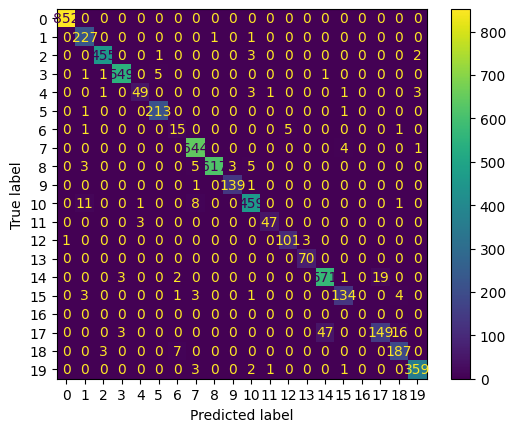

[[852   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 227   0   0   0   0   0   0   1   0   1   0   0   0   0   0   0   0
    0   0]
 [  0   0 455   0   0   1   0   0   0   0   3   0   0   0   0   0   0   0
    0   2]
 [  0   1   1 549   0   5   0   0   0   0   0   0   0   0   1   0   0   0
    0   0]
 [  0   0   1   0  49   0   0   0   0   0   3   1   0   0   0   1   0   0
    0   3]
 [  0   1   0   0   0 213   0   0   0   0   0   0   0   0   0   1   0   0
    0   0]
 [  0   1   0   0   0   0  15   0   0   0   0   0   5   0   0   0   0   0
    1   0]
 [  0   0   0   0   0   0   0 644   0   0   0   0   0   0   0   4   0   0
    0   1]
 [  0   3   0   0   0   0   0   5 617   3   5   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   1   0 139   1   0   0   0   0   0   0   0
    0   0]
 [  0  11   0   0   1   0   0   8   0   0 459   0   0   0   0   0   0   0
    1   0]
 [  0   0   0   0   3   0   0   0   0   0   0  47   0   0   0   0

In [10]:
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
print(cm)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred, average='macro')
#accuracy2 = accuracy_score(y_test2, y_pred2)
print("Accuracy 1 :", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
#print("Accuracy 2 :", accuracy2)

## Train on CNN-LSTM

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the path to the reorganized dataset folders
train_data_dir = 'D:/WLASL/KArSL/all Signers/Train'
test_data_dir = 'D:/WLASL/KArSL/all Signers/Test'
#test2_data_dir = 'D:/WLASL/KArSL/Signer_2/all_image_test'
# Create an ImageDataGenerator instance with appropriate data augmentation settings
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    validation_split=0.20,
    #rotation_range=0.2,  # Example augmentation settings, modify as needed
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    #brightness_range=[0.2,1.0]
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0  # Normalize pixel values
)
# Prepare the training data generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=64,
    shuffle=True,
    class_mode='categorical',
    seed=42,
    subset = "training"
)

val_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=64,
    shuffle=True,
    class_mode='categorical',
    seed=42,
    subset = "validation"
)


# Prepare the testing data generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 66519 images belonging to 20 classes.
Found 16620 images belonging to 20 classes.
Found 19101 images belonging to 20 classes.


In [3]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model = tf.keras.models.Sequential([
    #data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.7),
    tf.keras.layers.LSTM(32, dropout=0.7),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=["accuracy",
                      tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='AUC')])

model.fit(train_generator, epochs=200, batch_size=64
          , validation_data=val_generator, callbacks=[early_stopping, tensorboard_callback])
%tensorboard --logdir logs/fit

Epoch 1/200
1040/1040 [==============================] - 3512s 3s/step - loss: 1.7237 - accuracy: 0.3724 - precision: 0.8000 - recall: 0.1966 - AUC: 0.9108 - val_loss: 1.1790 - val_accuracy: 0.5637 - val_precision: 0.7219 - val_recall: 0.4839 - val_AUC: 0.9587
Epoch 2/200
1040/1040 [==============================] - 2289s 2s/step - loss: 0.6666 - accuracy: 0.7284 - precision: 0.8419 - recall: 0.6122 - AUC: 0.9869 - val_loss: 3.8689 - val_accuracy: 0.3398 - val_precision: 0.3771 - val_recall: 0.3214 - val_AUC: 0.7806
Epoch 3/200
1040/1040 [==============================] - 2703s 3s/step - loss: 0.4082 - accuracy: 0.8437 - precision: 0.8796 - recall: 0.7991 - AUC: 0.9941 - val_loss: 3.9956 - val_accuracy: 0.4104 - val_precision: 0.4251 - val_recall: 0.3987 - val_AUC: 0.7899
Epoch 4/200
1040/1040 [==============================] - 1572s 2s/step - loss: 0.2739 - accuracy: 0.9038 - precision: 0.9178 - recall: 0.8869 - AUC: 0.9963 - val_loss: 0.1211 - val_accuracy: 0.9740 - val_precision: 0.

Reusing TensorBoard on port 6006 (pid 29332), started 21 days, 17:03:11 ago. (Use '!kill 29332' to kill it.)

## Train on CNN model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model = tf.keras.models.Sequential([
    #data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=["accuracy",
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='AUC')])

model.fit(train_generator, epochs=200, batch_size=128
          , validation_data=val_generator, callbacks=[early_stopping, tensorboard_callback])
%tensorboard --logdir logs/fit

In [4]:
model.evaluate(test_generator)

299/299 [==============================] - 204s 682ms/step - loss: 0.2033 - accuracy: 0.9606 - precision: 0.9607 - recall: 0.9603 - AUC: 0.9919


[0.20329596102237701,
 0.9605779647827148,
 0.9607165455818176,
 0.9602638483047485,
 0.9918680787086487]

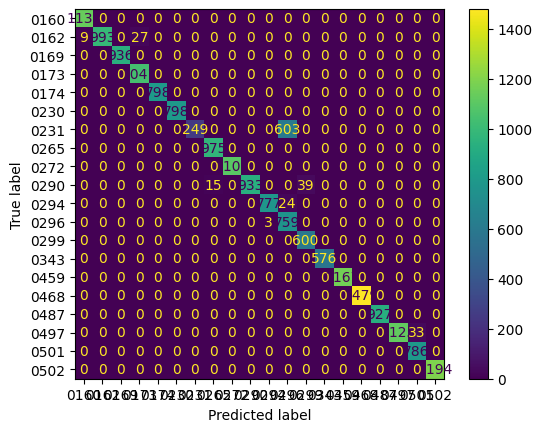

In [5]:
predictions = model.predict(test_generator)

# Convert predictions and true labels to arrays
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot()

In [6]:
model.save('D:/WLASL/KArSL/model_5_cnnlstm.h5')

In [2]:
model_1 = tf.keras.models.load_model('D:/WLASL/KArSL/model_5_cnnlstm.h5')

In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('D:/WLASL/KArSL/model_5_cnnlstm.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Ali\AppData\Local\Temp\tmpi5eqegpy\assets


ConverterError: Could not find SavedModel .pb or .pbtxt at supplied export directory path: C:\Users\Ali\AppData\Local\Temp\tmpi5eqegpy. Check that the directory exists and that you have the right permissions for accessing it.

In [10]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0